In [1]:
!pip install "jax[cpu]"==0.3.7 # need to use older version of jax fix temporary jax2tf bug (should be fixed in 0.3.11 release): "AttributeError: module 'tensorflow.compiler.tf2xla.python.xla' has no attribute 'optimization_barrier'"

     |████████████████████████████████| 944 kB 5.0 MB/s 
  Created wheel for jax: filename=jax-0.3.7-py3-none-any.whl size=1091304 sha256=6f90f53d792fe7464e843cb1a7fe3a45acad2f33e8ab760c05ff61e788ea53b6
  Stored in directory: /root/.cache/pip/wheels/c7/72/d4/a495bfbf37a64af5d4bd58d10625663abcf3ca3554a7d30637
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.8
    Uninstalling jax-0.3.8:
      Successfully uninstalled jax-0.3.8


In [2]:
!pip install -q git+https://github.com/google-research/vision_transformer

     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 186 kB 11.4 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 4.9 MB 37.3 MB/s 
     |████████████████████████████████| 288 kB 74.8 MB/s 
     |████████████████████████████████| 4.2 MB 36.6 MB/s 
     |████████████████████████████████| 140 kB 56.9 MB/s 
     |████████████████████████████████| 462 kB 44.4 MB/s 
     |████████████████████████████████| 72 kB 499 kB/s 


In [3]:
!pip install -U tf2onnx

     |████████████████████████████████| 440 kB 5.0 MB/s 
     |████████████████████████████████| 12.8 MB 58.4 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [4]:
import jax
import jax.numpy as jnp
from jax.experimental import jax2tf
import tensorflow as tf
from vit_jax import models
import tf2onnx

In [5]:
# Currently available LiT models
[name for name in models.model_configs.MODEL_CONFIGS if name.startswith('LiT')]

['LiT-B16B', 'LiT-L16L', 'LiT-L16S', 'LiT-L16Ti']

In [6]:
model_name = 'LiT-B16B'
lit_model = models.get_model(model_name)
lit_variables = lit_model.load_variables()
tokenizer = lit_model.get_tokenizer() # <-- this contains tensorflow code, so need to port manually :(
image_preprocessing = lit_model.get_image_preprocessing() # <-- this contains tensorflow code, so need to port manually :(

Loading params from cloud: gs://vit_models/lit/LiT-B16B.npz


100%|██████████| 75/75 [01:05<00:00,  1.15it/s]



⚠️ Reusing local copy: LiT-B16B.npz


In [ ]:
##################################
#         IMAGE MODEL            #
##################################

In [7]:
def embed_images(variables, images):
  zimg, _, _ = lit_model.apply(variables, images=images)
  return zimg

In [8]:
# This is so we don't save the model parameters as graph constants. Explanation here: https://github.com/google/jax/tree/main/jax/experimental/jax2tf#saved-model-with-parameters
lit_variables_tf = tf.nest.map_structure(tf.Variable, lit_variables)
embed_images_tf = lambda images: jax2tf.convert(embed_images, enable_xla=False, polymorphic_shapes=[None, "(b, ...)"])(lit_variables_tf, images)

In [17]:
!wget https://i.imgur.com/3EFG6xW.jpg

--2022-05-16 12:07:42--  https://i.imgur.com/3EFG6xW.jpg
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7465 (7.3K) [image/jpeg]
Saving to: ‘3EFG6xW.jpg’

3EFG6xW.jpg         100%[===================>]   7.29K  --.-KB/s    in 0s      

2022-05-16 12:07:42 (35.7 MB/s) - ‘3EFG6xW.jpg’ saved [7465/7465]



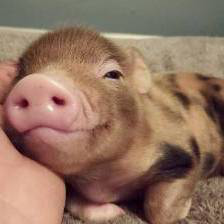

In [18]:
from PIL import Image
img = Image.open("/content/3EFG6xW.jpg") 
display(img)

In [19]:
np_img = jnp.asarray(img)

In [27]:
np_img

DeviceArray([[[104, 110, 100],
              [104, 110, 100],
              [104, 110, 100],
              ...,
              [102, 108,  98],
              [102, 108,  98],
              [102, 108,  98]],

             [[104, 110, 100],
              [104, 110, 100],
              [104, 110, 100],
              ...,
              [102, 108,  98],
              [102, 108,  98],
              [102, 108,  98]],

             [[103, 109,  99],
              [103, 109,  99],
              [104, 110, 100],
              ...,
              [102, 108,  98],
              [102, 108,  98],
              [102, 108,  98]],

             ...,

             [[218, 172, 149],
              [217, 171, 148],
              [216, 170, 147],
              ...,
              [120,  95,  75],
              [125, 100,  80],
              [126, 101,  81]],

             [[219, 173, 150],
              [217, 171, 148],
              [215, 169, 146],
              ...,
              [ 97,  72,  52],
          

In [20]:
print(np_img.shape)

(224, 224, 3)


In [21]:
pp_img = image_preprocessing(tf.convert_to_tensor(jnp.array([np_img])))

In [37]:
pp_img

array([[[[-0.18431371, -0.1372549 , -0.21568626],
         [-0.18431371, -0.1372549 , -0.21568626],
         [-0.18431371, -0.1372549 , -0.21568626],
         ...,
         [-0.19999999, -0.15294117, -0.23137254],
         [-0.19999999, -0.15294117, -0.23137254],
         [-0.19999999, -0.15294117, -0.23137254]],

        [[-0.18431371, -0.1372549 , -0.21568626],
         [-0.18431371, -0.1372549 , -0.21568626],
         [-0.18431371, -0.1372549 , -0.21568626],
         ...,
         [-0.19999999, -0.15294117, -0.23137254],
         [-0.19999999, -0.15294117, -0.23137254],
         [-0.19999999, -0.15294117, -0.23137254]],

        [[-0.19215685, -0.14509803, -0.2235294 ],
         [-0.19215685, -0.14509803, -0.2235294 ],
         [-0.18431371, -0.1372549 , -0.21568626],
         ...,
         [-0.19999999, -0.15294117, -0.23137254],
         [-0.19999999, -0.15294117, -0.23137254],
         [-0.19999999, -0.15294117, -0.23137254]],

        ...,

        [[ 0.70980394,  0.34901965,  0

In [14]:
pp_img.shape

(1, 224, 224, 3)

In [25]:
embed_images_tf(pp_img)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-5.55288605e-02,  5.64340614e-02, -2.53345165e-02,
        -7.04571372e-03, -4.43741232e-02, -9.98641457e-03,
         1.47062605e-02, -1.28184434e-03, -4.88287956e-03,
         3.44051234e-02, -3.47652510e-02, -2.54354160e-02,
        -1.67460516e-02, -4.55446541e-03, -2.95176860e-02,
         1.50395669e-02,  1.91923082e-02, -2.26781471e-03,
         5.53558804e-02, -2.05553714e-02, -1.90312341e-02,
         3.07557285e-02, -1.34337973e-02, -2.51099486e-02,
         4.73540509e-03,  7.24522024e-02, -2.76858658e-02,
         1.33900195e-02, -5.63910324e-03,  7.59580508e-02,
        -2.10811291e-02, -4.26671468e-02,  4.40267362e-02,
        -8.98994133e-03, -2.72203200e-02,  9.45691671e-03,
        -4.53936607e-02, -5.14366031e-02, -1.60149615e-02,
        -3.43620256e-02,  1.67564414e-02, -6.35175966e-03,
         2.28999201e-02, -1.53777329e-02, -6.26899628e-03,
        -2.14609914e-02,  2.90533844e-02, -1.50994482e-02,
      

In [ ]:
my_model = tf.Module()
my_model._variables = tf.nest.flatten(lit_variables_tf)
my_model.f = tf.function(embed_images_tf, autograph=False, jit_compile=True, input_signature=[
  tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name="images"),
])

model_name = 'embed_images'
tf.saved_model.save(my_model, model_name, options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

INFO:tensorflow:Assets written to: embed_images/assets


INFO:tensorflow:Assets written to: embed_images/assets


In [ ]:
# https://github.com/onnx/tensorflow-onnx#from_function-tf-20-and-newer
tf2onnx.convert.from_function(my_model.f, input_signature=[tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name="images")], opset=13, output_path=model_name+'.onnx')

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/embed_images.onnx /content/drive/MyDrive/embed_images.onnx

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
# tflite_model = converter.convert()

# with open(model_name+'.tflite', 'wb') as f:
#   f.write(tflite_model)

In [ ]:
##################################
#          TEXT MODEL            #
##################################

In [ ]:
def embed_text_tokens(variables, text_tokens):
  _, ztxt, _ = lit_model.apply(lit_variables, tokens=text_tokens)
  return ztxt

In [ ]:
# This is so we don't save the model parameters as graph constants. Explanation here: https://github.com/google/jax/tree/main/jax/experimental/jax2tf#saved-model-with-parameters
lit_variables_tf = tf.nest.map_structure(tf.Variable, lit_variables)
embed_text_tokens_tf = lambda text_tokens: jax2tf.convert(embed_text_tokens, enable_xla=False, polymorphic_shapes=[None, "(b, ...)"])(lit_variables_tf, text_tokens)

In [ ]:
texts = ["hello world!", "testing one two three", "hi", "aaaaaaaaaaaaaaaa"]

In [ ]:
text_tokens = tokenizer(texts)
text_tokens.shape

(4, 16)

In [ ]:
_, ztxt, _ = lit_model.apply(lit_variables, tokens=text_tokens)

In [ ]:
text_tokens

array([[  101,  7592,  2088,   999,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  101,  5604,  2028,  2048,  2093,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  101,  7632,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [  101, 13360, 11057, 11057, 11057, 11057, 11057, 11057,  2050,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)

In [ ]:
embed_text_tokens_tf(text_tokens)

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.00325142,  0.01848885,  0.00041978, ...,  0.00173793,
        -0.00536559, -0.06884101],
       [-0.01331316,  0.01797788,  0.00657475, ...,  0.00655348,
         0.02183297, -0.08194969],
       [ 0.00275494,  0.0236993 ,  0.0011628 , ...,  0.00860824,
         0.00814609, -0.05825125],
       [ 0.00415286,  0.00938824, -0.00084121, ...,  0.01578477,
         0.0134029 , -0.06656414]], dtype=float32)>

In [ ]:
my_model = tf.Module()
my_model._variables = tf.nest.flatten(lit_variables_tf)
my_model.f = tf.function(embed_text_tokens_tf, autograph=False, jit_compile=True, input_signature=[
  tf.TensorSpec(shape=[None, 16], dtype=tf.int32, name="text_tokens"),
])

model_name = 'embed_text_tokens'
tf.saved_model.save(my_model, model_name, options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

INFO:tensorflow:Assets written to: embed_text_tokens/assets


INFO:tensorflow:Assets written to: embed_text_tokens/assets


In [ ]:
# https://github.com/onnx/tensorflow-onnx#from_function-tf-20-and-newer
tf2onnx.convert.from_function(my_model.f, input_signature=[tf.TensorSpec(shape=[None, 16], dtype=tf.int32, name="text_tokens")], opset=13, output_path=model_name+'.onnx')

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp /content/embed_text_tokens.onnx /content/drive/MyDrive/embed_text_tokens.onnx

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
# tflite_model = converter.convert()

# with open(model_name+'.tflite', 'wb') as f:
#   f.write(tflite_model)

In [ ]:
#!python -m tf2onnx.convert --opset 13 --tflite embed_images.tflite --output embed_images.onnx # fails due to lack of TFL_BATCH_MATMUL support: https://github.com/onnx/tensorflow-onnx/issues/1925